# Imports and Installs

In [2]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
# import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Imports form ML (Decision Trees)
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# 0) One DataFrame with Dummies
* including newly defined "month-week_of_month"

## 0.1) Read and truncate data (last 25 years from 2000), define variable sets




In [4]:
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab
# truncated data from Module 2: https://drive.google.com/file/d/1m3Qisfs2XfWk6Sw_Uk5kHLWqwQ0q8SKb/view?usp=sharing
# !gdown https://drive.google.com/file/d/1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB/view?usp=sharing --fuzzy -O /content/

In [5]:
# truncated
# df = pd.read_parquet("/content/stocks_df_combined_trunc_2014_2023.parquet.brotli", )

# full dataset for 33 stocks
df_full = pd.read_parquet("./stocks_df_combined_2025_06_13.parquet.brotli", )

In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230262 entries, 0 to 5700
Columns: 203 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 302.2+ MB


In [7]:
# growth indicators (but not future growth)
GROWTH = [g for g in df_full.keys() if (g.find('growth_')==0)&(g.find('future')<0)]
GROWTH

['growth_1d',
 'growth_3d',
 'growth_7d',
 'growth_30d',
 'growth_90d',
 'growth_365d',
 'growth_dax_1d',
 'growth_dax_3d',
 'growth_dax_7d',
 'growth_dax_30d',
 'growth_dax_90d',
 'growth_dax_365d',
 'growth_snp500_1d',
 'growth_snp500_3d',
 'growth_snp500_7d',
 'growth_snp500_30d',
 'growth_snp500_90d',
 'growth_snp500_365d',
 'growth_dji_1d',
 'growth_dji_3d',
 'growth_dji_7d',
 'growth_dji_30d',
 'growth_dji_90d',
 'growth_dji_365d',
 'growth_epi_1d',
 'growth_epi_3d',
 'growth_epi_7d',
 'growth_epi_30d',
 'growth_epi_90d',
 'growth_epi_365d',
 'growth_gold_1d',
 'growth_gold_3d',
 'growth_gold_7d',
 'growth_gold_30d',
 'growth_gold_90d',
 'growth_gold_365d',
 'growth_wti_oil_1d',
 'growth_wti_oil_3d',
 'growth_wti_oil_7d',
 'growth_wti_oil_30d',
 'growth_wti_oil_90d',
 'growth_wti_oil_365d',
 'growth_brent_oil_1d',
 'growth_brent_oil_3d',
 'growth_brent_oil_7d',
 'growth_brent_oil_30d',
 'growth_brent_oil_90d',
 'growth_brent_oil_365d',
 'growth_btc_usd_1d',
 'growth_btc_usd_3d',


In [8]:
df_full.keys()

Index(['Open', 'High', 'Low', 'Close_x', 'Volume', 'Dividends', 'Stock Splits',
       'Ticker', 'Year', 'Month',
       ...
       'growth_brent_oil_7d', 'growth_brent_oil_30d', 'growth_brent_oil_90d',
       'growth_brent_oil_365d', 'growth_btc_usd_1d', 'growth_btc_usd_3d',
       'growth_btc_usd_7d', 'growth_btc_usd_30d', 'growth_btc_usd_90d',
       'growth_btc_usd_365d'],
      dtype='object', length=203)

In [9]:
# leaving only Volume ==> generate ln(Volume)
OHLCV = ['Open','High','Low','Close_x','Volume']

In [10]:
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']

In [11]:
TO_PREDICT = [g for g in df_full.keys() if (g.find('future')>=0)]
TO_PREDICT

['growth_future_30d', 'is_positive_growth_30d_future']

In [12]:
# we define dummy variables on Dividends and Stock Splits events later, but drop the original abs. values
TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Close_y','Dividends','Stock Splits'] + CATEGORICAL + OHLCV
TO_DROP

['Year',
 'Date',
 'index_x',
 'index_y',
 'index',
 'Quarter',
 'Close_y',
 'Dividends',
 'Stock Splits',
 'Month',
 'Weekday',
 'Ticker',
 'ticker_type',
 'Open',
 'High',
 'Low',
 'Close_x',
 'Volume']

In [13]:
# let's define on more custom numerical features
# Add a small constant to avoid log(0)
df_full['ln_volume'] = df_full.Volume.apply(lambda x: np.log(x+ 1e-6))

In [14]:
# define columns on Dividends or Stock Splits
df_full['div_payout'] = (df_full.Dividends>0).astype(int)
df_full['stock_split'] = (df_full['Stock Splits']>0).astype(int)

In [15]:
# manually defined features
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 
                    'ln_volume','div_payout','stock_split']

In [16]:
# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']

In [17]:
TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')

Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']


In [18]:
MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']

In [19]:
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

In [20]:
# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df_full.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP + TO_PREDICT]
OTHER

[]

In [21]:
df_full.Ticker.nunique()

33

In [22]:
# truncated df_full with 25 years of data (and defined growth variables)
df = df_full[df_full.Date>='2000-01-01']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 206 entries, Open to stock_split
dtypes: datetime64[ns](3), float64(130), int32(64), int64(7), object(2)
memory usage: 256.1+ MB


In [23]:
# tickers, min-max date, count of daily observations
df.groupby(['Ticker'])['Date'].agg(['min','max','count'])

,min,max,count
Ticker,,,
AAPL,2000-01-03,2025-06-13,6401
ACN,2001-07-19,2025-06-13,6012
AMZN,2000-01-03,2025-06-13,6401
ASML,2000-01-03,2025-06-13,6401
AVGO,2009-08-06,2025-06-13,3989
BHARTIARTL.NS,2002-07-01,2025-06-13,5698
BRK-B,2000-01-03,2025-06-13,6401
CDI.PA,2000-01-03,2025-06-13,6540
GOOG,2004-08-19,2025-06-13,5239


## 0.2) Dummies

In [24]:
# what are the categorical features?
CATEGORICAL

['Month', 'Weekday', 'Ticker', 'ticker_type']

In [25]:
# dummy variables are not generated from Date and numeric variables

# df.loc[:,'Month'] = df['Month'].dt.strftime('%B').astype('string')

df.loc[:,'Month']= pd.to_datetime(df['Month'], format='%m').dt.strftime('%B')

df.loc[:,'Weekday'] = df['Weekday'].astype('string')
# .astype(str)

/var/folders/rj/25gyk3bn7_g60b0fxzrg3jn40000gq/T/ipykernel_76057/2619569166.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['January' 'January' 'January' ... 'June' 'June' 'June']' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.loc[:,'Month']= pd.to_datetime(df['Month'], format='%m').dt.strftime('%B')
/var/folders/rj/25gyk3bn7_g60b0fxzrg3jn40000gq/T/ipykernel_76057/2619569166.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<StringArray>
['0', '1', '2', '3', '4', '0', '1', '2', '3', '4',
 ...
 '0', '1', '2', '3', '4', '0', '1', '2', '3', '4']
Length: 191795, dtype: string' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[:,'Weekday'] = df['Weekday'].astype('string')


### 0.2.1) Create a new string column 'month_wom' (month_week_of_month)

In [26]:
# define week of month
df.loc[:,'wom'] = df.Date.apply(lambda d: (d.day-1)//7 + 1)
# convert to string
df.loc[:,'wom'] = df.loc[:,'wom'].astype(str)

/var/folders/rj/25gyk3bn7_g60b0fxzrg3jn40000gq/T/ipykernel_76057/1081537706.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1' '1' '1' ... '2' '2' '2']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:,'wom'] = df.loc[:,'wom'].astype(str)


In [27]:
# check values for week-of-month (should be between 1 and 5)
df.wom.value_counts()

wom
2    45083
3    44006
4    43753
1    43557
5    15396
Name: count, dtype: int64

In [28]:
df.loc[:,'month_wom'] = df.Month + '_w' + df.wom

In [29]:
# examples of encoding
df.month_wom.value_counts()[0:2]

month_wom
June_w1        3882
February_w1    3878
Name: count, dtype: int64

In [30]:
# del wom temp variable
del df['wom']

### 0.2.2) Generate all dummies

In [31]:
# what are the categorical features?
CATEGORICAL.append('month_wom')
CATEGORICAL

['Month', 'Weekday', 'Ticker', 'ticker_type', 'month_wom']

In [32]:
# Generate dummy variables (no need for bool, let's have int32 instead)
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')

In [33]:
dummy_variables.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 115 entries, Month_April to month_wom_September_w5
dtypes: int32(115)
memory usage: 85.6 MB


In [34]:
# get dummies names in a list
DUMMIES = dummy_variables.keys().to_list()
DUMMIES

['Month_April',
 'Month_August',
 'Month_December',
 'Month_February',
 'Month_January',
 'Month_July',
 'Month_June',
 'Month_March',
 'Month_May',
 'Month_November',
 'Month_October',
 'Month_September',
 'Weekday_0',
 'Weekday_1',
 'Weekday_2',
 'Weekday_3',
 'Weekday_4',
 'Weekday_5',
 'Weekday_6',
 'Ticker_AAPL',
 'Ticker_ACN',
 'Ticker_AMZN',
 'Ticker_ASML',
 'Ticker_AVGO',
 'Ticker_BHARTIARTL.NS',
 'Ticker_BRK-B',
 'Ticker_CDI.PA',
 'Ticker_GOOG',
 'Ticker_HDB',
 'Ticker_HINDUNILVR.NS',
 'Ticker_IBN',
 'Ticker_IDEXY',
 'Ticker_INFY',
 'Ticker_ITC.NS',
 'Ticker_JPM',
 'Ticker_LICI.NS',
 'Ticker_LLY',
 'Ticker_LT.NS',
 'Ticker_MC.PA',
 'Ticker_META',
 'Ticker_MSFT',
 'Ticker_NVDA',
 'Ticker_NVO',
 'Ticker_OR.PA',
 'Ticker_RELIANCE.NS',
 'Ticker_RMS.PA',
 'Ticker_SAP',
 'Ticker_SBIN.NS',
 'Ticker_SIE.DE',
 'Ticker_TCS.NS',
 'Ticker_TTE',
 'Ticker_V',
 'ticker_type_EU',
 'ticker_type_INDIA',
 'ticker_type_US',
 'month_wom_April_w1',
 'month_wom_April_w2',
 'month_wom_April_w3',
 'mo

In [35]:
len(DUMMIES)

115

In [36]:
# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df, dummy_variables], axis=1)

In [37]:
df_with_dummies[NUMERICAL+DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 301 entries, growth_1d to month_wom_September_w5
dtypes: float64(121), int32(177), int64(3)
memory usage: 312.4 MB


### 1.2.3) Get correlations for month_wom (month-week_of_month) with is_futur

In [38]:
DUMMIES_MONTH_WOM = [k for k in DUMMIES if k.startswith('month_wom')]
# check a few records
DUMMIES_MONTH_WOM[0:2]

['month_wom_April_w1', 'month_wom_April_w2']

In [39]:
corr_month_wom_vs_is_positive_growth_30d_future = df_with_dummies[DUMMIES_MONTH_WOM+TO_PREDICT].corr()['is_positive_growth_30d_future']

In [40]:
corr_month_wom_vs_is_positive_growth_30d_future

month_wom_April_w1              -0.001600
month_wom_April_w2              -0.002640
month_wom_April_w3               0.006208
month_wom_April_w4               0.004110
month_wom_April_w5               0.001731
                                   ...   
month_wom_September_w3          -0.006012
month_wom_September_w4           0.013558
month_wom_September_w5           0.012684
growth_future_30d                0.696468
is_positive_growth_30d_future    1.000000
Name: is_positive_growth_30d_future, Length: 62, dtype: float64

In [41]:
# create a dataframe for an easy way to sort
corr_month_wom_vs_is_positive_growth_30d_future_df = pd.DataFrame(corr_month_wom_vs_is_positive_growth_30d_future)

In [42]:
# rename column 'is_positive_growth_5d_future' to 'corr'
corr_month_wom_vs_is_positive_growth_30d_future_df.rename(columns={'is_positive_growth_30d_future':'corr'},inplace=True)

In [43]:
corr_month_wom_vs_is_positive_growth_30d_future_df.loc[:, 'abs_corr'] = corr_month_wom_vs_is_positive_growth_30d_future_df['corr'].abs()

In [44]:
corr_month_wom_vs_is_positive_growth_30d_future_df.sort_values(by='abs_corr')

,corr,abs_corr
month_wom_July_w1,-0.000010,0.000010
month_wom_March_w1,0.000244,0.000244
month_wom_May_w4,-0.000609,0.000609
month_wom_February_w5,0.001553,0.001553
month_wom_April_w1,-0.001600,0.001600
...,...,...
month_wom_November_w2,0.018822,0.018822
month_wom_November_w3,0.022097,0.022097
month_wom_October_w4,0.024968,0.024968
growth_future_30d,0.696468,0.696468


In [45]:
# ANSWER Q1 HA3: # TOP CORR NEW DUMMY with is_positive: ANSWER 0.025 (rounded to 3 digits)

### 1.2.4) Temporal split

In [46]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.6).
        val_prop (float): Proportion of data for validation set (default: 0.2).
        test_prop (float): Proportion of data for test set (default: 0.2).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

In [47]:
min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [48]:
df_with_dummies['split'].value_counts()/len(df_with_dummies)

split
train         0.676399
test          0.163758
validation    0.159843
Name: count, dtype: float64

In [49]:
# remove the "segmentation" problem (warning message on df performance after many joins and data transformations)
new_df = df_with_dummies.copy()

# 1) Modeling

In [50]:
# Full dataframe (transformed and truncated to 25 years)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 323 entries, Open to split
dtypes: datetime64[ns](2), float64(130), int32(178), int64(7), object(5), string(1)
memory usage: 343.9+ MB


In [51]:
# check one record: it has abs. values, text, and numbers
new_df.head(1)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,month_wom_October_w2,month_wom_October_w3,month_wom_October_w4,month_wom_October_w5,month_wom_September_w1,month_wom_September_w2,month_wom_September_w3,month_wom_September_w4,month_wom_September_w5,split
3490,35.975752,36.358881,34.3283,35.726719,53228400.0,0.0,0.0,MSFT,2000,January,...,0,0,0,0,0,0,0,0,0,train


In [52]:
# time split on train/validation/test: FIXED dates of split, approx. 70%, 15%, 15% split
new_df.groupby(['split'])['Date'].agg({'min','max','count'})

,count,max,min
split,,,
test,31408,2025-06-13,2021-08-20
train,129730,2017-10-25,2000-01-03
validation,30657,2021-08-19,2017-10-26


In [53]:
# check for imbalances of growth for train/test/validation
new_df.groupby(by='split')['growth_future_30d'].describe()

,count,mean,std,min,25%,50%,75%,max
split,,,,,,,,
test,30418.0,1.019899,0.102172,0.580332,0.955986,1.016057,1.077950,1.648934
train,129730.0,1.023864,0.123190,0.246131,0.960248,1.020585,1.083310,5.179689
validation,30657.0,1.029596,0.099908,0.461847,0.973991,1.030784,1.086687,1.783610


In [54]:
# what do we try to predict
new_df[TO_PREDICT].head(1)

,growth_future_30d,is_positive_growth_30d_future
3490,0.845576,0


In [55]:
# to be used as features
new_df[NUMERICAL+DUMMIES].head(1)

,growth_1d,growth_3d,growth_7d,growth_30d,growth_90d,growth_365d,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,...,month_wom_October_w1,month_wom_October_w2,month_wom_October_w3,month_wom_October_w4,month_wom_October_w5,month_wom_September_w1,month_wom_September_w2,month_wom_September_w3,month_wom_September_w4,month_wom_September_w5
3490,0.998394,0.988341,0.991494,1.372333,1.22295,2.063054,0.970196,0.983855,1.051736,1.134572,...,0,0,0,0,0,0,0,0,0,0


## 1.1) Manual 'rule of thumb' predictions
* (pred0) CCI>200 (binary, on technical indicator CCI)
* (pred1) growth_30d>1
* (pred2) (growth_30d>1) & (growth_snp500_30d>1)
* (pred3) (DGS10 <= 4) & (DGS5 <= 1)
* (pred4) (DGS10 > 4) & (FEDFUNDS <= 4.795)

In [56]:
# generate manual predictions
# Let's label all prediction features with prefix "pred"
new_df['pred0_manual_cci'] = (new_df.cci>200).astype(int)
new_df['pred1_manual_prev_g1'] = (new_df.growth_30d>1).astype(int)
new_df['pred2_manual_prev_g1_and_snp'] = ((new_df['growth_30d'] > 1) & (new_df['growth_snp500_30d'] > 1)).astype(int)

In [57]:
# new manual predictions from HA
new_df['pred3_manual_dgs10_5'] = ((new_df['DGS10'] <= 4) & (new_df['DGS5'] <= 1)).astype(int)
new_df['pred4_manual_dgs10_fedfunds'] = ((new_df['DGS10'] > 4) & (new_df['FEDFUNDS'] <= 4.795)).astype(int)

In [58]:
# sample of 10 observations and predictions
new_df[['cci','growth_30d','growth_snp500_30d','pred0_manual_cci','pred1_manual_prev_g1','pred2_manual_prev_g1_and_snp','pred3_manual_dgs10_5','pred4_manual_dgs10_fedfunds','is_positive_growth_30d_future']].sample(10)

,cci,growth_30d,growth_snp500_30d,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_dgs10_5,pred4_manual_dgs10_fedfunds,is_positive_growth_30d_future
2342,-90.963513,0.994081,0.992753,0,0,0,0,1,0
239,-82.315315,0.836269,0.890528,0,0,0,0,1,1
3032,-98.427628,0.860375,1.051790,0,0,0,0,0,1
4359,-60.408872,0.960895,1.010520,0,0,0,1,0,0
3226,-200.192435,0.847218,0.999584,0,0,0,0,0,0
3973,-72.073969,1.021974,0.981862,0,1,0,0,0,0
8115,53.612913,0.854797,1.040317,0,0,0,1,0,0
2254,-129.117416,0.855510,1.021129,0,0,0,0,1,0
3187,110.183454,1.010921,0.986057,0,1,0,0,0,1
9133,59.952054,0.972979,0.968474,0,0,0,0,0,0


In [59]:
# List of current predictions
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds']

In [60]:
# Function to find all predictions (starting from 'pred'), generate is_correct (correctness of each prediction)
# and precision on TEST dataset (assuming there is df["split"] column with values 'train','validation','test'

# returns 2 lists of features: PREDICTIONS and IS_CORRECT

def get_predictions_correctness(df:pd.DataFrame, to_predict:str):
  PREDICTIONS = [k for k in df.keys() if k.startswith('pred')]
  print(f'Prediction columns founded: {PREDICTIONS}')

  # add columns is_correct_
  for pred in PREDICTIONS:
    part1 = pred.split('_')[0] # first prefix before '_'
    df[f'is_correct_{part1}'] =  (new_df[pred] == new_df[to_predict]).astype(int)

  # IS_CORRECT features set
  IS_CORRECT =  [k for k in df.keys() if k.startswith('is_correct_')]
  print(f'Created columns is_correct: {IS_CORRECT}')

  print('Precision on TEST set for each prediction:')
  # define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
  for i,column in enumerate(IS_CORRECT):
    prediction_column = PREDICTIONS[i]
    is_correct_column = column
    filter = (new_df.split=='test') & (new_df[prediction_column]==1)
    print(f'Prediction column:{prediction_column} , is_correct_column: {is_correct_column}')
    print(new_df[filter][is_correct_column].value_counts())
    print(new_df[filter][is_correct_column].value_counts()/len(new_df[filter]))
    print('---------')

  return PREDICTIONS, IS_CORRECT

In [61]:
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict='is_positive_growth_30d_future')

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    443
0    351
Name: count, dtype: int64
is_correct_pred0
1    0.557935
0    0.442065
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    9748
0    8243
Name: count, dtype: int64
is_correct_pred1
1    0.541826
0    0.458174
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    6984
0    6383
Name: count, dtype: int64
is_correct_pred2
1    0.522481
0    0.477519
Name: count, dtype: float64
-------

In [62]:
# sample of 10 predictions vs. is_correct vs. is_positive_growth_30d_future (what we're trying to predict)
new_df[PREDICTIONS+IS_CORRECT+['is_positive_growth_30d_future']].sample(10)

,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_dgs10_5,pred4_manual_dgs10_fedfunds,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,is_positive_growth_30d_future
4496,0,0,0,0,0,1,1,1,1,1,0
9179,1,1,1,0,0,1,1,1,0,0,1
244,0,0,0,0,1,0,0,0,0,1,1
523,0,0,0,0,0,0,0,0,0,0,1
3061,0,1,0,0,1,0,1,0,0,1,1
6212,0,0,0,1,0,1,1,1,0,1,0
3925,0,1,0,0,0,0,1,0,0,0,1
6190,0,1,1,0,0,0,1,1,0,0,1
1895,0,1,1,0,0,0,1,1,0,0,1
2263,0,0,0,0,0,1,1,1,1,1,0


In [63]:
len(new_df[new_df.split=='test'])

31408

In [64]:
# ANSWER Q2: best is pred3_manual_dgs10_5 with precision = 0.580 (rounded)

In [65]:
# pred4 seems to be empty on Test - let's check why?

# it used to be some stats
new_df[(new_df['gdppot_us_yoy'] >= 0.027) & (new_df['growth_wti_oil_30d'] <= 1.005)]

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_dgs10_5,pred4_manual_dgs10_fedfunds,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4
3682,17.010899,17.547278,16.934273,16.972586,81099400.0,0.0,0.0,MSFT,2000,October,...,0,0,0,0,0,0,0,0,0,0
3683,17.106682,17.394028,16.781023,17.030056,61794000.0,0.0,0.0,MSFT,2000,October,...,0,0,0,0,0,0,0,0,0,0
3684,17.049210,17.087522,16.244640,16.608612,58323600.0,0.0,0.0,MSFT,2000,October,...,0,0,0,0,0,0,0,0,0,0
3689,16.397884,16.493666,15.191030,15.440063,119759000.0,0.0,0.0,MSFT,2000,October,...,0,0,0,0,0,0,0,0,0,0
3690,15.899824,16.072232,15.401757,15.459227,81276600.0,0.0,0.0,MSFT,2000,October,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1690,115.265769,115.265769,112.248964,112.965836,1009151.0,0.0,0.0,HINDUNILVR.NS,2002,June,...,0,0,0,0,1,1,1,1,1,0
1691,113.503511,115.773583,113.115213,113.981422,1117609.0,0.0,0.0,HINDUNILVR.NS,2002,June,...,0,0,0,0,1,1,1,1,1,0
1692,118.879979,118.879979,113.951538,114.847618,703080.0,0.0,0.0,HINDUNILVR.NS,2002,June,...,0,0,0,0,1,1,1,1,1,0
1693,115.893030,116.191724,113.145047,113.443741,1403644.0,0.0,0.0,HINDUNILVR.NS,2002,June,...,0,0,0,0,1,1,1,1,1,0


## 1.2) Decision Tree Classifier

### 1.2.1) Defining Functions to clean_df(), fit_decision_tree(), predict_decision_tree()
* here we utilize only Decision Tree Classifier (and not Regressor)

In [66]:
# Prepare a dataframe for ML:
  # +-inf to NaN, all NaNs to 0s
def clean_dataframe_from_inf_and_nan(df:pd.DataFrame):
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
  df.fillna(0, inplace=True)
  return df

In [67]:
# Estimation/fit function (using dataframe of features X and what to predict y) --> optimising total accuracy
# max_depth is hyperParameter
def fit_decision_tree(X, y, max_depth=20):
# Initialize the Decision Tree Classifier
  clf = DecisionTreeClassifier(max_depth=max_depth,
                               random_state=42)

  # Fit the classifier to the training data
  clf.fit(X, y)
  return clf, X.columns

### 1.2.2) CLF10 (Decision Tree Classifier, max_depth==10): get unique correct predictions vs. pred0_manual...pred4_manual
* Fit(Train) on TRAIN+VALIDATION
* Predict on ALL and Join to the original new_df
* Get Precision on TEST

In [68]:
# Features to be used in predictions (incl. new dummies)
features_list = NUMERICAL+DUMMIES
# What we're trying to predict?
to_predict = 'is_positive_growth_30d_future'

train_valid_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)
test_df = new_df[new_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
X_train_valid = train_valid_df[features_list+[to_predict]]
X_test = test_df[features_list+[to_predict]]

# this to be used for predictions and join to the original dataframe new_df
X_all =  new_df[features_list+[to_predict]].copy(deep=True)

print(f'length: X_train_valid {X_train_valid.shape},  X_test {X_test.shape}, all combined: X_all {X_all.shape}')


length: X_train_valid (160387, 302),  X_test (31408, 302), all combined: X_all (191795, 302)


In [69]:
# Clean from +-inf and NaNs:

X_train_valid = clean_dataframe_from_inf_and_nan(X_train_valid)
# X_test = clean_dataframe_from_inf_and_nan(X_test) # won't use
X_all = clean_dataframe_from_inf_and_nan(X_all)

In [70]:
y_train_valid = X_train_valid[to_predict]
# y_test = X_test[to_predict] # won't use
y_all =  X_all[to_predict]

# remove y_train, y_test from X_ dataframes
del X_train_valid[to_predict]
del X_test[to_predict]
del X_all[to_predict]

In [71]:
%%time
clf_10, train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=10)

CPU times: user 13.8 s, sys: 132 ms, total: 14 s
Wall time: 14.1 s


In [72]:
X_train_valid.shape

(160387, 301)

In [73]:
X_all.shape

(191795, 301)

In [74]:
y_all.shape

(191795,)

In [75]:
# predict on a full dataset
y_pred_all = clf_10.predict(X_all)

In [76]:
# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred5_clf_10'] = y_pred_all

In [77]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict='is_positive_growth_30d_future')

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds', 'pred5_clf_10']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    443
0    351
Name: count, dtype: int64
is_correct_pred0
1    0.557935
0    0.442065
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    9748
0    8243
Name: count, dtype: int64
is_correct_pred1
1    0.541826
0    0.458174
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    6984
0    6383
Name: count, dtype: int64
is_correct_pred2
1    0.522481
0    0.477519

In [78]:
IS_CORRECT

['is_correct_pred0',
 'is_correct_pred1',
 'is_correct_pred2',
 'is_correct_pred3',
 'is_correct_pred4',
 'is_correct_pred5']

In [79]:
# define a new column that find the cases when only pred5 is correct
new_df['only_pred5_is_correct'] = (new_df.is_correct_pred5==new_df.is_positive_growth_30d_future) & \
                         (new_df.is_positive_growth_30d_future == 1) & \
                         (new_df.is_correct_pred0 == 0) & \
                         (new_df.is_correct_pred1 == 0) & \
                         (new_df.is_correct_pred2 == 0) & \
                         (new_df.is_correct_pred3 == 0) & \
                         (new_df.is_correct_pred4 == 0)

In [80]:
# need it to be integer and not bool
new_df['only_pred5_is_correct'] = new_df['only_pred5_is_correct'].astype(int)

In [81]:
# how many times only pred5 is correct in the TEST set?
new_df[new_df.split=='test']['only_pred5_is_correct'].sum()

np.int64(3624)

In [82]:
# let's look at the record
filter_unique_pred_5 = (new_df.split=='test') & (new_df.only_pred5_is_correct==1)

In [83]:
# sample with only Pred5 correct
new_df[filter_unique_pred_5].sample(10)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,pred3_manual_dgs10_5,pred4_manual_dgs10_fedfunds,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,pred5_clf_10,is_correct_pred5,only_pred5_is_correct
7905,49.417937,51.206059,48.955338,51.206059,3093200.0,0.0,0.0,TTE,2023,March,...,0,0,0,0,0,0,0,1,1,1
5994,16.931764,17.148837,16.856260,17.082771,10440400.0,0.0,0.0,INFY,2023,January,...,0,0,0,0,0,0,0,1,1,1
6664,100.121756,102.839743,98.281459,100.235008,1672700.0,0.0,0.0,SAP,2022,March,...,0,0,0,0,0,0,0,1,1,1
5120,3018.716512,3031.633379,2974.683666,2982.990967,1815297.0,0.0,0.0,TCS.NS,2023,March,...,0,0,0,0,0,0,0,1,1,1
7016,133.494767,133.504638,131.144259,131.559067,829500.0,0.0,0.0,SAP,2023,August,...,0,0,0,0,0,0,0,1,1,1
4842,132.571967,133.317535,131.985457,132.850311,16409900.0,0.0,0.0,GOOG,2023,November,...,0,0,0,0,0,0,0,1,1,1
7657,42.186347,42.556771,42.110578,42.363140,2787500.0,0.0,0.0,TTE,2022,March,...,0,0,0,0,0,0,0,1,1,1
6585,1044.654131,1059.966218,1018.660458,1026.706177,17983310.0,0.0,0.0,RELIANCE.NS,2022,March,...,0,0,0,0,0,0,0,1,1,1
6976,130.660343,130.689970,129.633224,129.870255,515100.0,0.0,0.0,SAP,2023,June,...,0,0,0,0,0,0,0,1,1,1
10452,50.284168,50.553272,49.909344,49.967010,1533600.0,0.0,0.0,NVO,2022,October,...,0,0,0,0,0,0,0,1,1,1


In [84]:
# let's visually check that all predictions are 0, but pred5==1 (sample 10)
new_df[filter_unique_pred_5][PREDICTIONS+IS_CORRECT+['is_positive_growth_30d_future']].sample(10)

,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_dgs10_5,pred4_manual_dgs10_fedfunds,pred5_clf_10,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,is_correct_pred5,is_positive_growth_30d_future
7918,0,0,0,0,0,1,0,0,0,0,0,1,1
349,0,0,0,0,0,1,0,0,0,0,0,1,1
6902,0,0,0,0,0,1,0,0,0,0,0,1,1
6642,0,0,0,0,0,1,0,0,0,0,0,1,1
3001,0,0,0,0,0,1,0,0,0,0,0,1,1
5843,0,0,0,0,0,1,0,0,0,0,0,1,1
6896,0,0,0,0,0,1,0,0,0,0,0,1,1
6918,0,0,0,0,0,1,0,0,0,0,0,1,1
6116,0,0,0,0,0,1,0,0,0,0,0,1,1
11017,0,0,0,0,0,1,0,0,0,0,0,1,1


In [85]:
# ANSWER HA3: 3659 unique correct prediction from clf_10 (on test)

## 1.2.3 [Code Snippet 2] Hyperparams tuning for a Decision Tree Classifier

In [86]:
# TODO HA: Define DUMMIES_SHORT to include only original dummies (and exclude too detailed dummies like month_week_of_month, let's leave only month) --> less features

In [87]:
# Features to be used in predictions (incl. new dummies)
features_list = NUMERICAL+DUMMIES
# What we're trying to predict?
to_predict = 'is_positive_growth_30d_future'

train_df = new_df[new_df.split.isin(['train'])].copy(deep=True)
valid_df = new_df[new_df.split.isin(['validation'])].copy(deep=True)
train_valid_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)

test_df =  new_df[new_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
X_train = train_df[features_list+[to_predict]]
X_valid = valid_df[features_list+[to_predict]]

X_train_valid = train_valid_df[features_list+[to_predict]]

X_test = test_df[features_list+[to_predict]]

# this to be used for predictions and join to the original dataframe new_df
X_all =  new_df[features_list+[to_predict]].copy(deep=True)

print(f'length: X_train {X_train.shape},  X_validation {X_valid.shape}, X_test {X_test.shape}, X_train_valid = {X_train_valid.shape},  all combined: X_all {X_all.shape}')

length: X_train (129730, 302),  X_validation (30657, 302), X_test (31408, 302), X_train_valid = (160387, 302),  all combined: X_all (191795, 302)


In [88]:
# Clean from +-inf and NaNs:

X_train = clean_dataframe_from_inf_and_nan(X_train)
X_valid = clean_dataframe_from_inf_and_nan(X_valid)
X_train_valid = clean_dataframe_from_inf_and_nan(X_train_valid)

X_test = clean_dataframe_from_inf_and_nan(X_test)

X_all = clean_dataframe_from_inf_and_nan(X_all)

In [89]:
y_train = X_train[to_predict]
y_valid = X_valid[to_predict]

y_train_valid = X_train_valid[to_predict]
y_test = X_test[to_predict]
y_all =  X_all[to_predict]

# remove y_train, y_test from X_ dataframes
del X_train[to_predict]
del X_valid[to_predict]
del X_train_valid[to_predict]

del X_test[to_predict]

del X_all[to_predict]

In [90]:
# visualisation: decision tree for a few levels (max_depth variable)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/20156951/how-do-i-find-which-attributes-my-tree-splits-on-when-using-scikit-learn
from sklearn.tree import export_text


In [91]:
# (8min runtime) UNCOMMENT TO RUN IT AGAIN
# %%time
# # hyper params tuning for a Decision Tree

# precision_by_depth = {}
# best_precision = 0
# best_depth = 0

# for depth in range(1,21):
#   print(f'Working with a tree of a max depth= {depth}')
#   # fitting the tree on X_train, y_train
#   clf,train_columns = fit_decision_tree(X=X_train_valid,
#                            y=y_train_valid,
#                            max_depth=depth) #applying custom hyperparam
#   # getting the predictions for TEST and accuracy score
#   y_pred_valid = clf.predict(X_valid)
#   precision_valid = precision_score(y_valid, y_pred_valid)
#   y_pred_test = clf.predict(X_test)
#   precision_test = precision_score(y_test, y_pred_test)
#   print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')
#   # saving to the dict
#   precision_by_depth[depth] = round(precision_test,4)
#   # updating the best precision
#   if precision_test >= best_precision:
#     best_precision = round(precision_test,4)
#     best_depth = depth
#   # plot tree - long
#   # plt.figure(figsize=(20,10))  # Set the size of the figure
#   # plot_tree(clf,
#   #           filled=True,
#   #           feature_names=train_columns,
#   #           class_names=['Negative', 'Positive'],
#   #           max_depth=2)
#   # plt.show()
#   # plot tree - short
#   tree_rules = export_text(clf, feature_names=list(X_train), max_depth=3)
#   print(tree_rules)
#   print('------------------------------')

# print(f'All precisions by depth: {precision_by_depth}')
# print(f'The best precision is {best_precision} and the best depth is {best_depth} ')

In [92]:
# Results of Hyper parameters tuning for a Decision Tree
# print(precision_by_depth)

In [93]:
# pre-calculated results
precision_by_depth = {1: 0.5466, 2: 0.5511, 3: 0.5511, 4: 0.5511, 5: 0.6278, 6: 0.5691, 7: 0.5945, 8: 0.5891, 9: 0.5912, 10: 0.5888, 11: 0.5916, 12: 0.5855, 13: 0.5822, 14: 0.592, 15: 0.5833, 16: 0.5898, 17: 0.586, 18: 0.5861, 19: 0.5869, 20: 0.5773}




In [94]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(precision_by_depth.items()), columns=['max_depth', 'precision_score'])
df.loc[:,'precision_score'] = df.precision_score*100.0 # need for % visualisation

# Create the bar chart using Plotly Express
fig = px.bar(df,
             x='max_depth',
             y='precision_score',
            #  title='Precision Score vs. Max Depth for a Decision Tree',
             labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score'},
             range_y=[54, 65],
             text='precision_score')

# Update the text format to display as percentages
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Center the title
fig.update_layout(title={'text': 'Precision Score vs. Max Depth for a Decision Tree', 'x': 0.5, 'xanchor': 'center'})


# Show the figure
fig.show()

In [95]:
%%time
clf_5, train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=5)


# predict on a full dataset
y_pred_all = clf_5.predict(X_all)


# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred6_clf_5'] = y_pred_all

CPU times: user 7.56 s, sys: 325 ms, total: 7.89 s
Wall time: 7.99 s


In [96]:
# MANUAL SECOND BEST, need some complexity
# found earlier in HyperParams Tuning
best_depth = 14
best_precision = precision_by_depth[best_depth]

In [97]:
print(f'Best precision and depth = {best_depth}, precision (on test)={best_precision}')

Best precision and depth = 14, precision (on test)=0.592


In [98]:
%%time
clf_best, train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=best_depth)

CPU times: user 17.9 s, sys: 119 ms, total: 18 s
Wall time: 18 s


In [99]:
# For a DecisionTreeClassifier in scikit-learn, the concept of trainable parameters differs from that of neural networks.
# In decision trees, the parameters are the structure of the tree itself (nodes and splits) rather than weights.
# However, you can still get a sense of the model's complexity by looking at the number of nodes and leaves.

# Here's how you can get this information for your trained DecisionTreeClassifier (referred to as clf_best):

# Get the number of nodes and leaves in the tree
n_nodes = clf_best.tree_.node_count
n_leaves = clf_best.get_n_leaves()

print(f"Number of nodes: {n_nodes}")
print(f"Number of leaves: {n_leaves}")

Number of nodes: 4613
Number of leaves: 2307


In [100]:
clf_best

,criterion,'gini'
,splitter,'best'
,max_depth,14
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [101]:
# predict on a full dataset
y_pred_clf_best = clf_best.predict(X_all)

In [102]:
# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred7_clf_second_best'] = y_pred_clf_best

In [103]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict='is_positive_growth_30d_future')

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds', 'pred5_clf_10', 'pred6_clf_5', 'pred7_clf_second_best']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6', 'is_correct_pred7']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    443
0    351
Name: count, dtype: int64
is_correct_pred0
1    0.557935
0    0.442065
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    9748
0    8243
Name: count, dtype: int64
is_correct_pred1
1    0.541826
0    0.458174
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    6984


### 1.2.4) Two ways of visualisation

In [104]:
# train a simple tree
clf_2,train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=2)

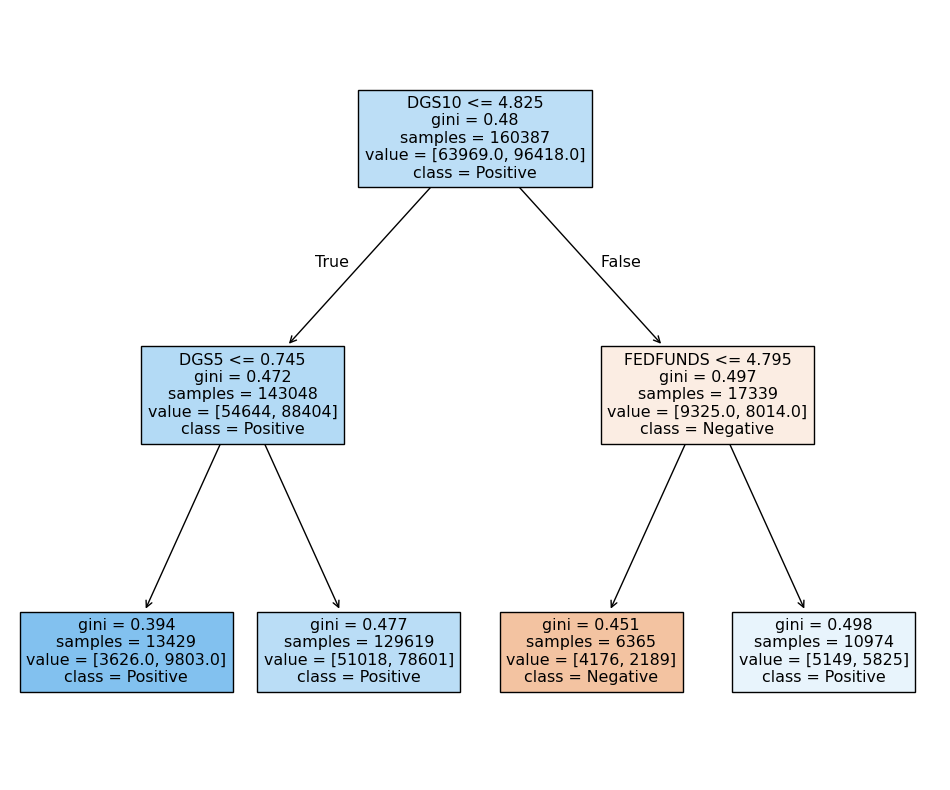

In [105]:
# Visualisation: decision tree for a few levels (max_depth variable)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming clf_2 is your trained DecisionTreeClassifier
plt.figure(figsize=(12,10))  # Set the size of the figure
plot_tree(clf_2,
          filled=True,
          feature_names=train_columns,
          class_names=['Negative', 'Positive'],
          max_depth=2)
plt.show()

In [106]:
  tree_rules = export_text(clf_2, feature_names=list(X_train), max_depth=1)
  print(tree_rules)

|--- DGS10 <= 4.83
|   |--- DGS5 <= 0.75
|   |   |--- class: 1
|   |--- DGS5 >  0.75
|   |   |--- class: 1
|--- DGS10 >  4.83
|   |--- FEDFUNDS <= 4.80
|   |   |--- class: 0
|   |--- FEDFUNDS >  4.80
|   |   |--- class: 1



## 1.3) [Code Snippet 3] Random Forest
https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles

In [107]:
from sklearn.ensemble import RandomForestClassifier
import time

# (12 min runtime FOR v28 machine) UNCOMMENT BELOW TO RUN HYPERPARAMs optimisation again

In [108]:
# %%time
# # hyper params tuning

# precision_matrix = {}
# best_precision = 0
# best_depth = 0
# best_estimators = 1

# for depth in [5, 7, 9, 11, 13, 15, 17, 19]:
#   for estimators in [10,50,100,200]:
#     print(f'Working with HyperParams: depth = {depth}, estimators = {estimators}')

#     # Start timing
#     start_time = time.time()
#     # fitting the tree on X_train, y_train
#     rf = RandomForestClassifier(n_estimators = estimators,
#                                 max_depth = depth,
#                                 random_state = 42,
#                                 n_jobs = -1)

#     rf = rf.fit(X_train_valid, y_train_valid)

#     # getting the predictions for TEST and accuracy score
#     y_pred_valid = rf.predict(X_valid)
#     precision_valid = precision_score(y_valid, y_pred_valid)
#     y_pred_test = rf.predict(X_test)
#     precision_test = precision_score(y_test, y_pred_test)
#     print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')

#     # saving to the dict
#     precision_matrix[depth, estimators] = round(precision_test,4)

#     # Measure elapsed time
#     elapsed_time = time.time() - start_time
#     print(f'Time for training: {elapsed_time:.2f} seconds, or {elapsed_time/60:.2f} minutes')

#     # updating the best precision
#     if precision_test >= best_precision:
#       best_precision = round(precision_test,4)
#       best_depth = depth
#       best_estimators = estimators
#       print(f'New best precision found for depth={depth}, estimators = {estimators}')

#     print('------------------------------')

# print(f'Matrix of precisions: {precision_matrix}')
# print(f'The best precision is {best_precision} and the best depth is {best_depth} ')

In [109]:
# uncomment when you run the hyperparam tuning again
# print(precision_matrix)

In [110]:
# pre-calculated best precision matrix (max_depth, n_estimators) for Random Forest
best_precision_matrix_random_forest = best_precision_matrix_random_forest = {
    (5, 10): 0.5498,
    (5, 50): 0.5511,
    (5, 100): 0.5511,
    (5, 200): 0.5511,
    (7, 10): 0.5540,
    (7, 50): 0.5492,
    (7, 100): 0.5495,
    (7, 200): 0.5515,
    (9, 10): 0.5411,
    (9, 50): 0.5461,
    (9, 100): 0.5507,
    (9, 200): 0.5517,
    (11, 10): 0.5623,
    (11, 50): 0.5559,
    (11, 100): 0.5565,
    (11, 200): 0.5521,
    (13, 10): 0.5510,
    (13, 50): 0.5591,
    (13, 100): 0.5614,
    (13, 200): 0.5575,
    (15, 10): 0.5596,
    (15, 50): 0.5592,
    (15, 100): 0.5585,
    (15, 200): 0.5505,
    (17, 10): 0.5538,
    (17, 50): 0.5543,
    (17, 100): 0.5510,
    (17, 200): 0.5493,
    (19, 10): 0.5611,
    (19, 50): 0.5559,
    (19, 100): 0.5599,
    (19, 200): 0.5544,
}

In [111]:
# # Define the precision_matrix from the long calculation above
# best_precision_matrix = {
#      (5, 10): 0.5498, (5, 20): 0.5506,
#      (5, 50): 0.5511, (5, 100): 0.5511,
#      (6, 10): 0.5555, (6, 20): 0.551,
#      (6, 50): 0.5498, (6, 100): 0.5509,
#      (7, 10): 0.554, (7, 20): 0.5478,
#      (7, 50): 0.5492, (7, 100): 0.5495,
#      (8, 10): 0.5475, (8, 20): 0.5425,
#      (8, 50): 0.5516, (8, 100): 0.5507}


In [112]:
# Convert data to DataFrame
df = pd.DataFrame.from_dict(best_precision_matrix_random_forest, orient='index', columns=['precision_score']).reset_index()

# Rename the columns for clarity
df.columns = ['max_depth_and_metric', 'precision_score']

# Separate the tuple into two columns
df[['max_depth', 'n_estimators']] = pd.DataFrame(df['max_depth_and_metric'].tolist(), index=df.index)

# Drop the combined column
df = df.drop(columns=['max_depth_and_metric'])

# Create line plot using Plotly Express
fig = px.line(df, x='max_depth', y='precision_score', color='n_estimators',
              labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score', 'n_estimators': 'Number of Estimators'},
              title='Random Forest Models: Precision Score vs. Max Depth for Different Number of Estimators')

# Adjust x-axis range
fig.update_xaxes(range=[5, 20])

# Show the figure
fig.show()

In [113]:
# MANUALLY SELECTED BEST - should have enough complexity and smoothness (n_estimators)
rf_best_n_estimators = 50
# MANUALLY SELECTED BEST - should have enough complexity
rf_best_max_depth = 19

In [114]:
%%time

#
# several minutes to compute (2 min)

rf_best = RandomForestClassifier(n_estimators = rf_best_n_estimators,
                                 max_depth = rf_best_max_depth,
                                 random_state = 42,
                                 n_jobs = -1)

rf_best = rf_best.fit(X_train_valid, y_train_valid)

CPU times: user 50.5 s, sys: 384 ms, total: 50.9 s
Wall time: 6.26 s


## 1.4) [Code Snippet 1] Logistic Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

There can be many cases when Logistic Regression does not converge: https://forecastegy.com/posts/how-to-solve-logistic-regression-not-converging-in-scikit-learn/

In [115]:
from sklearn.linear_model import LogisticRegression

In [116]:
# Large feature magnitudes can cause convergence issues. If you haven’t already, scale your data:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_valid = scaler.fit_transform(X_train_valid)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [117]:
# UNCOMMENT TO RUN IT AGAIN

# precision_matrix = {}
# best_precision = 0
# best_C = 0
# best_iter = 0

# for c in [1, 0.1, 0.01]:
#   for iter in [50, 100, 200]:
#     print(f'Working with HyperParams: C = {c} (positive float, smaller = stronger regularization), max_iter={iter}')
#     # fitting the tree on X_train, y_train
#     # hyperParam C should be between 0 and 1
#     lr = LogisticRegression(C=c,
#                             random_state=42,
#                             max_iter=iter,
#                             solver='sag',  # 'sag' - another option
#                             n_jobs=-1)

#     lr = lr.fit(X_train_valid, y_train_valid)

#     # getting the predictions for TEST and accuracy score
#     y_pred_valid = lr.predict(X_valid)
#     precision_valid = precision_score(y_valid, y_pred_valid)
#     y_pred_test = lr.predict(X_test)
#     precision_test = precision_score(y_test, y_pred_test)
#     print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')
#     # saving to the dict
#     precision_matrix[(c,iter)] = round(precision_test,4)
#     # updating the best precision
#     if precision_test >= best_precision:
#       best_precision = round(precision_test,4)
#       best_C = c
#       best_iter = iter
#       print(f'New best precision found for C={c}')
#       print('------------------------------')

# print(f'Matrix of precisions: {precision_matrix}')
# print(f'The best precision is {best_precision} and the best C is {best_C}, best max_iter = {best_iter}  ')

In [118]:
# UNCOMMENT TO SEE THE RESULTS OF THE RUN
# print(precision_matrix)

In [119]:
# Params on C, iter
best_precision_matrix_logistic_regression = {(1, 50): 0.5459, (1, 100): 0.5367, (1, 200): 0.5277, (0.1, 50): 0.5466, (0.1, 100): 0.5373, (0.1, 200): 0.5285, (0.01, 50): 0.5476, (0.01, 100): 0.5428, (0.01, 200): 0.54}


In [120]:
list(best_precision_matrix_logistic_regression.items())[0]

((1, 50), 0.5459)

In [121]:
# Prepare the data
rows = []
for key, value in list(best_precision_matrix_logistic_regression.items()):
    C, max_iter = key
    combination_label = f'C={C}, max_iter={max_iter}'
    rows.append({'Combination': combination_label, 'Precision': value})

df = pd.DataFrame(rows)
df.loc[:,'Precision'] = df.Precision*100.0 # need for % visualisation

# Create the bar chart
fig = px.bar(df,
             x='Combination',
             y='Precision',
             text='Precision'
             )

# Customize the layout for better readability
fig.update_layout(
    xaxis_title='Hyperparams combinations of <C, Max Iterations>',
    yaxis_title='Precision Score',
    xaxis_tickangle=-45,
    title={
        'text': 'Precision Scores for Various Logistic Regression Hyperparameter Combinations',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)


# Update the text position
fig.update_traces(texttemplate='%{text:.2f}%',
                  textposition='inside',
                  textfont_color='white')

# Show the figure
fig.show()

## 1.5) [Code Snippet 4 - ADVANCED] Neural Network (NN) and HyperParams tuning
* [Tutorial from Tensorflow.org](https://www.tensorflow.org/tutorials/keras/classification)
* [TowardsDataScience Hyperparameter Optimization with Keras](https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53)
* [Machine Learning Mastery tutorial with Keras Deep Learning](https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/)

In [122]:
# https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53


# Extended params set

# p = {'lr': [0.01, 0.03,0.1, 0.3,1,3,10],
#      'first_neuron': [0,16,32,64,128,256],
#      'second_neuron':[0,16,32,64,128,256],
#      'first_dropout':[0,0.2,0.3],
#      'second_dropout':[0,0.2,0.3],
#      'activation_first':['relu','sigmoid','linear'],
#      'activation_second':['relu','sigmoid','linear'],
#     #  'activation_first':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
#     #  'activation_second':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
#     #  'batch_size':(2,30,10),
#     #  'loss': ('mse','mae'),
#     #  'epochs':[150],
#     #  'shape': ['brick','long_funnel'],
#      'optimizer':['adam', 'nadam', 'rmaprop','sgd'],
#     #  'losses': [logcosh, binary_crossentropy],
#     #  'last_activation':[sigmoid]
#      }


# Reduced params set and available options
p = {'lr': [0.1],
     'first_neuron': [12,24,32,48,96, 128, 196, 256],
     'second_neuron':[12,24,32,48,96, 128, 196, 256],
     'first_dropout':[0.1],
     'second_dropout':[0.1],
     'activation_first':['relu','sigmoid','softplus','tanh'],
     'activation_second':['relu'],
    #  'activation_first':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
    #  'activation_second':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
    #  'batch_size':(2,30,10),
    #  'loss': ('mse','mae'),
    #  'epochs':[150],
    #  'shape': ['brick','long_funnel'],
     'optimizer':['adam','nadam','sgd','rmaprop'],
    #  'losses': [logcosh, binary_crossentropy],
    #  'last_activation':[sigmoid]
     }


# Number of models to run and write to SHEETS:
count_models=0

nn_params = {}

for lr in p['lr']:
  for first_neuron in p['first_neuron']:
    for second_neuron in p['second_neuron']:
      for first_dropout in p['first_dropout']:
        for second_dropout in p['second_dropout']:
          for activation_first in p['activation_first']:
            for activation_second in p['activation_second']:
              for optimizer in p['optimizer']:
                # print(lr,first_neuron,second_neuron,first_dropout,second_dropout,activation_first,activation_second,optimizer,sep='/')
                count_models=count_models+1
                nn_params['learning_rate'] = lr
                nn_params['first_layer_neurons'] = first_neuron
                nn_params['first_layer_dropout'] = first_dropout
                nn_params['second_layer_neurons'] = second_neuron
                nn_params['second_layer_dropout'] = second_dropout
                nn_params['activation_first_layer'] = activation_first
                nn_params['activation_second_layer'] = activation_second
                nn_params['optimizer'] = optimizer
                # features count as an input shape
                nn_params['input_shape'] = len(X_train.keys())

# Current set of models to try
print(count_models)

1024


In [123]:
nn_params

{'learning_rate': 0.1,
 'first_layer_neurons': 256,
 'first_layer_dropout': 0.1,
 'second_layer_neurons': 256,
 'second_layer_dropout': 0.1,
 'activation_first_layer': 'tanh',
 'activation_second_layer': 'relu',
 'optimizer': 'rmaprop',
 'input_shape': 301}

In [124]:
# you need to install TF if using a v28 machine
# !pip install tensorflow

In [134]:
# UNCOMMENT TO RUN IT
# # returns best_model (trained) and best_history (history of train operations)
# best_model, best_history = train_neural_network_with_hyperparams(HYPER_PARAMS_SPACE=p,
#                                                                  MAX_MODELS=2, #not more than 2 models
#                                                                  MAX_EPOCHS=250,
#                                                                  EARLY_STOPPING_PATIENCE=10
#                                                                  )

In [135]:
# UNCOMMENT WHEN RUN AGAIN

# best_history_nn = best_history
# best_model_nn = best_model

In [136]:
# best_model_nn.summary()

In [137]:
# check the best history of training
# best_history

In [125]:
# pre computed history
best_history_nn ={'accuracy': [0.6206425428390503,
  0.6563935875892639,
  0.6715070605278015,
  0.6781659126281738,
  0.6846689581871033,
  0.6899000406265259,
  0.6924314498901367,
  0.6940774321556091,
  0.6963594555854797,
  0.6981488466262817,
  0.6982797980308533,
  0.7005742192268372],
 'loss': [0.6485477089881897,
  0.6164013743400574,
  0.6015466451644897,
  0.5939826965332031,
  0.5864177346229553,
  0.5822728872299194,
  0.5788451433181763,
  0.5766140818595886,
  0.5728825926780701,
  0.5714946389198303,
  0.5709761381149292,
  0.5681091547012329],
 'precision_1': [0.6281318068504333,
  0.6705082058906555,
  0.6927300691604614,
  0.7030346393585205,
  0.7096523642539978,
  0.7157368659973145,
  0.7195449471473694,
  0.7237764596939087,
  0.724949061870575,
  0.7277039289474487,
  0.7285037040710449,
  0.7305046916007996],
 'val_accuracy': [0.5095517039299011,
  0.5176388025283813,
  0.5059220790863037,
  0.49360036849975586,
  0.4926133453845978,
  0.4922631084918976,
  0.49605196714401245,
  0.48605450987815857,
  0.48605450987815857,
  0.4821383059024811,
  0.47784003615379333,
  0.4782857894897461],
 'val_loss': [0.7736297845840454,
  0.9822676181793213,
  1.0234887599945068,
  1.1025390625,
  1.1842303276062012,
  1.1674247980117798,
  1.1660196781158447,
  1.2397290468215942,
  1.2409558296203613,
  1.2863727807998657,
  1.3408353328704834,
  1.328245759010315],
 'val_precision_1': [0.5571497082710266,
  0.5591427087783813,
  0.5572323799133301,
  0.5471343398094177,
  0.5460649728775024,
  0.546144962310791,
  0.5497111082077026,
  0.5439006090164185,
  0.5426294207572937,
  0.5389731526374817,
  0.5362157225608826,
  0.5376880168914795]}

In [126]:
X_train_valid.shape

(160387, 301)

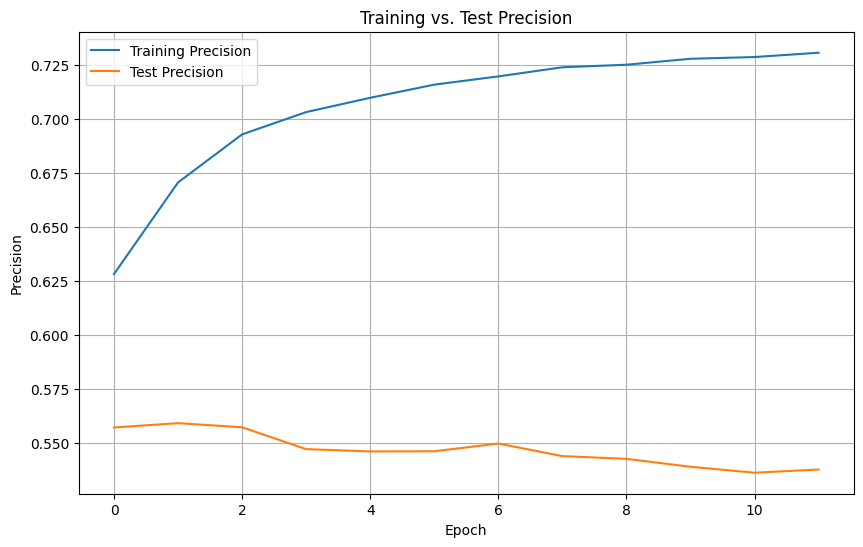

In [127]:
# Learning visualisation for the Deep Neural Network (DNN)
# The model is not actually training, as the precision and accuracy score are not improving on TRAIN/TEST with more Epochs

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(best_history_nn['precision_1'], label='Training Precision')
plt.plot(best_history_nn['val_precision_1'], label='Test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training vs. Test Precision')
plt.legend()
plt.grid(True)
plt.show()

# 2) [Code Snippet 5] Different Decision rules to improve the Precision (varying Threshold)
* best model1 **(clf_best)**: Decision Tree (max_depth=15)
* best model2 **(rf_best)**: Random Forest (n_estimators=200, max_depth=17)

## 2.1. Predicting probabilities (predict_proba), getting the distribution for probabilities, and new decision rules

In [128]:
# predicting probability instead of a label
y_pred_test = clf_best.predict_proba(X_test)

# y_pred_test = rf_best.predict_proba(X_test)

y_pred_test_class1 = [k[1] for k in y_pred_test] # k[1] is the second element in the list of Class predictions

/Users/iuliia/projects/market_zoomcamp/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



In [129]:
# example prediction
y_pred_test

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], shape=(31408, 2))

In [130]:
y_pred_test_class1_df = pd.DataFrame(y_pred_test_class1, columns=['Class1_probability'])

# sample of predictions
y_pred_test_class1_df.sample(10)

,Class1_probability
18955,0.000000
24996,0.071429
29780,0.000000
19694,0.000000
12372,0.000000
25641,0.000000
2407,0.000000
9895,0.000000
17486,1.000000
1827,0.000000


In [131]:
# Mean prediction is 0.3, median is 0.0, 75% quantile is 0.9
y_pred_test_class1_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Class1_probability,31408.0,0.309824,0.446348,0.0,0.0,0.0,0.90538,1.0


In [132]:
# Unconditional probability of a positive growth is 55.5%
y_test.sum()/y_test.count()

np.float64(0.5510697911360163)

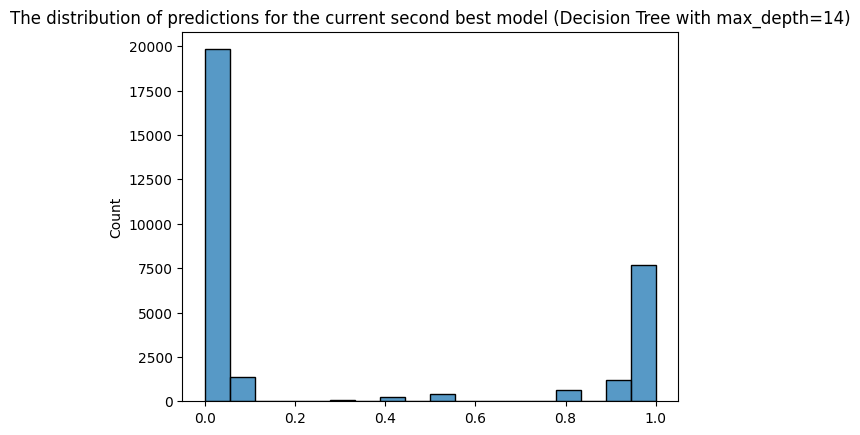

In [133]:
sns.histplot(y_pred_test_class1)

# Add a title
plt.title(f'The distribution of predictions for the current second best model (Decision Tree with max_depth={clf_best.get_depth()})')

# Show the plot
plt.show()

In [134]:
# tpr (True Positive Rate) vs. fpr (False Positive Rate) dataframe
# tp = True Positive
# tn = True Negative
# fp = False Positive
# fn = False Negative
# Decision Rule :  "y_pred>= Threshold" for Class "1"

# when only_even=True --> we'll have a step ==0.02 and leave only even records

def tpr_fpr_dataframe(y_true, y_pred, only_even=False):
    scores = []

    if only_even==False:
      thresholds = np.linspace(0, 1, 101) #[0, 0.01, 0.02, ...0.99,1.0]
    else:
      thresholds = np.linspace(0, 1, 51) #[0, 0.02, 0.04,  ...0.98,1.0]

    for t in thresholds:

        actual_positive = (y_true == 1)
        actual_negative = (y_true == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        if tp + fp > 0:
          precision = tp / (tp + fp)

        if tp + fn > 0:
          recall = tp / (tp + fn)

        if precision+recall > 0:
          f1_score = 2*precision*recall / (precision+recall)

        accuracy = (tp+tn) / (tp+tn+fp+fn)

        scores.append((t, tp, fp, fn, tn, precision, recall, accuracy, f1_score))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn','precision','recall', 'accuracy','f1_score']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores


In [135]:
df_scores = tpr_fpr_dataframe(y_test,
                              y_pred_test_class1,
                              only_even=True)

In [136]:
# full df_scores
df_scores

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
0,0.00,17308,14100,0,0,0.551070,1.000000,0.551070,0.710567,1.000000,1.000000
1,0.02,6279,5304,11029,8796,0.542088,0.362780,0.479973,0.434668,0.362780,0.376170
2,0.04,6279,5304,11029,8796,0.542088,0.362780,0.479973,0.434668,0.362780,0.376170
3,0.06,6279,5304,11029,8796,0.542088,0.362780,0.479973,0.434668,0.362780,0.376170
4,0.08,5686,4609,11622,9491,0.552307,0.328519,0.483221,0.411984,0.328519,0.326879
5,0.10,5629,4605,11679,9495,0.550029,0.325225,0.481533,0.408758,0.325225,0.326596
6,0.12,5629,4605,11679,9495,0.550029,0.325225,0.481533,0.408758,0.325225,0.326596
7,0.14,5629,4605,11679,9495,0.550029,0.325225,0.481533,0.408758,0.325225,0.326596
8,0.16,5629,4605,11679,9495,0.550029,0.325225,0.481533,0.408758,0.325225,0.326596
9,0.18,5629,4605,11679,9495,0.550029,0.325225,0.481533,0.408758,0.325225,0.326596


In [137]:
df_scores[(df_scores.threshold>=0.6) & (df_scores.threshold<=0.92)]

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
30,0.60,5291,4256,12017,9844,0.554206,0.305697,0.481884,0.394042,0.305697,0.301844
31,0.62,5291,4256,12017,9844,0.554206,0.305697,0.481884,0.394042,0.305697,0.301844
32,0.64,5291,4256,12017,9844,0.554206,0.305697,0.481884,0.394042,0.305697,0.301844
33,0.66,5291,4256,12017,9844,0.554206,0.305697,0.481884,0.394042,0.305697,0.301844
34,0.68,5291,4256,12017,9844,0.554206,0.305697,0.481884,0.394042,0.305697,0.301844
35,0.70,5291,4256,12017,9844,0.554206,0.305697,0.481884,0.394042,0.305697,0.301844
36,0.72,5291,4256,12017,9844,0.554206,0.305697,0.481884,0.394042,0.305697,0.301844
37,0.74,5291,4256,12017,9844,0.554206,0.305697,0.481884,0.394042,0.305697,0.301844
38,0.76,5291,4256,12017,9844,0.554206,0.305697,0.481884,0.394042,0.305697,0.301844
39,0.78,5291,4256,12017,9844,0.554206,0.305697,0.481884,0.394042,0.305697,0.301844


In [138]:
# TODO: HA to build a similar dataframe for random_forest and find optimal thresholds

<Axes: title={'center': 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=15)'}, xlabel='threshold'>

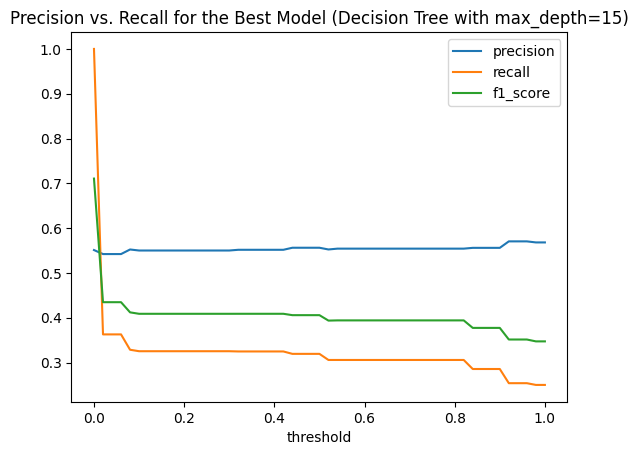

In [139]:
# Try to find high Precision score points

df_scores.plot.line(x='threshold',
                    y=['precision','recall', 'f1_score'],
                    title = 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=15)')

## 2.2) [Code Snippet 6] Defining new columns with Predictions in new_df: pred7..pred10
* pred7 and pred8 are 2 decision rules for the Decision Tree (best model with max_depth=15)
* pred9 and pred10 are 2 decision rules for the Random Forest (second best model)

In [140]:
# existing predictions
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds',
 'pred5_clf_10',
 'pred6_clf_5',
 'pred7_clf_second_best']

In [141]:
# adding Decision Tree predictors (clf_best) to the dataset for 2 new rules: Threshold = 0.66 and 0.78


y_pred_all = clf_best.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list

# defining a new prediction vector is easy now, as the dimensions will match
new_df['proba_pred8'] = y_pred_all_class1_array
new_df['pred8_clf_second_best_rule_84'] = (y_pred_all_class1_array >= 0.84).astype(int)

new_df['proba_pred9'] = y_pred_all_class1_array
new_df['pred9_clf_second_best_rule_92'] = (y_pred_all_class1_array >= 0.92).astype(int)

In [142]:
# adding Random Forest predictors (rf_best)
rf_best

,n_estimators,50
,criterion,'gini'
,max_depth,19
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [143]:
# make predictions of probabilities using the Random Forest model (rf_best)

y_pred_all = rf_best.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list


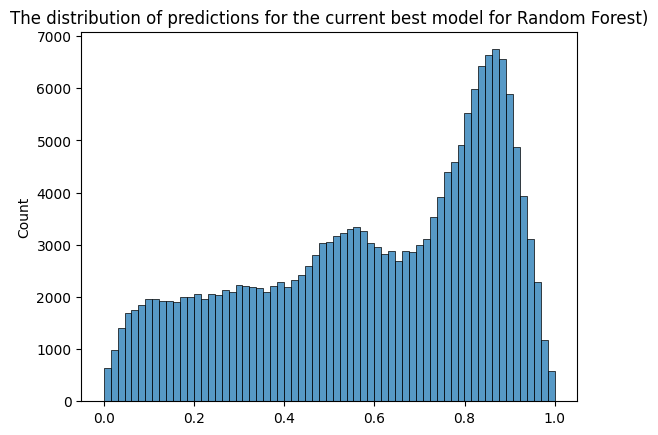

In [144]:
# PREDICTIONS ON A FULL DATASET - more smooth dataset - good sign
sns.histplot(y_pred_all_class1)

# Add a title
plt.title('The distribution of predictions for the current best model for Random Forest)')

# Show the plot
plt.show()

In [145]:
# adding Random Forest predictors (rf_best) to the dataset for 2 new rules: Threshold = 0.60 and 0.70
# defining a new prediction vector is easy now, as the dimensions will match
new_df['proba_pred10'] = y_pred_all_class1_array
new_df['pred10_rf_best_rule_55'] = (y_pred_all_class1_array >= 0.55).astype(int)

new_df['proba_pred11'] = y_pred_all_class1_array
new_df['pred11_rf_best_rule_65'] = (y_pred_all_class1_array >= 0.65).astype(int)

<Axes: >

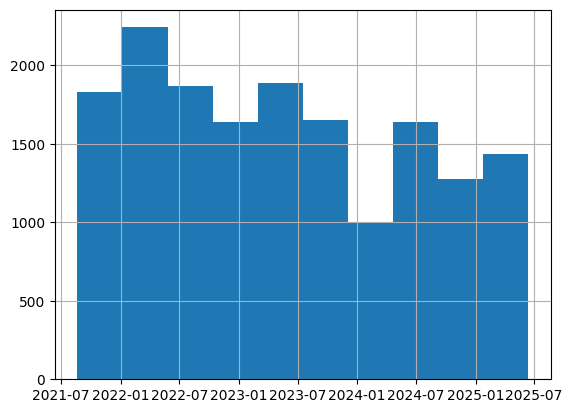

In [146]:
# Many positive predictions
new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_55==1)].Date.hist()

<Axes: >

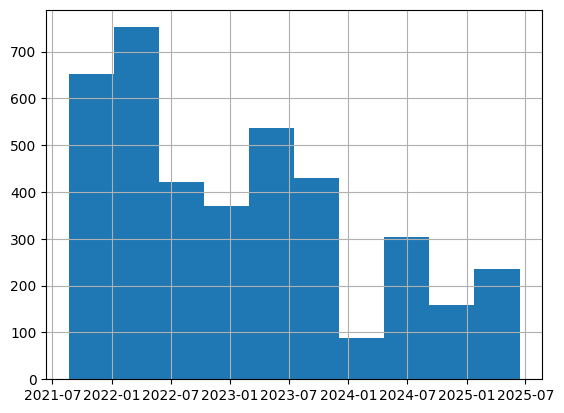

In [147]:
# When did it predict to trade for the "rare" positive prediction pred10?
new_df[(new_df.split=='test')&(new_df.pred11_rf_best_rule_65==1)].Date.hist()

In [148]:
# sample of rare predictions with high threshold
new_df[(new_df.split=='test')&(new_df.pred11_rf_best_rule_65==1)].sort_values(by='Date').sample(10)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,is_correct_pred6,is_correct_pred7,proba_pred8,pred8_clf_second_best_rule_84,proba_pred9,pred9_clf_second_best_rule_92,proba_pred10,pred10_rf_best_rule_55,proba_pred11,pred11_rf_best_rule_65
2520,179.703055,182.818362,175.283880,180.429626,50406300.0,0.0,0.0,META,2022,May,...,1,1,0.000000,0,0.000000,0,0.709605,1,0.709605,1
4914,3138.413689,3138.413689,3006.123436,3019.085449,3548046.0,22.0,0.0,TCS.NS,2022,May,...,0,1,0.889412,1,0.889412,0,0.696415,1,0.696415,1
5479,20.479497,20.762984,20.362192,20.411068,8925300.0,0.0,0.0,IBN,2022,January,...,1,0,0.969325,1,0.969325,1,0.705749,1,0.705749,1
6582,2104.060151,2144.228572,2066.091476,2076.707275,2997629.0,0.0,0.0,HINDUNILVR.NS,2022,February,...,1,1,0.000000,0,0.000000,0,0.748139,1,0.748139,1
6628,444.199376,449.367722,440.940051,442.523163,10884328.0,0.0,0.0,SBIN.NS,2022,May,...,1,1,0.146341,0,0.146341,0,0.680750,1,0.680750,1
4116,253.745398,259.314926,253.745398,257.587463,7062200.0,0.0,0.0,V,2024,July,...,1,1,0.976496,1,0.976496,1,0.673050,1,0.673050,1
3225,52.733775,54.926288,52.538635,54.721764,37301000.0,0.0,0.0,AVGO,2022,May,...,1,1,0.111111,0,0.111111,0,0.663029,1,0.663029,1
9321,249.604614,250.095884,246.431012,249.270554,17340200.0,0.0,0.0,MSFT,2023,March,...,1,1,1.000000,1,1.000000,1,0.663334,1,0.663334,1
5944,16.740235,17.141702,16.674880,17.085682,7393300.0,0.0,0.0,INFY,2022,October,...,1,1,0.976441,1,0.976441,1,0.697748,1,0.697748,1
10768,126.278507,128.135264,126.044068,128.060242,7925300.0,0.0,0.0,JPM,2022,November,...,1,1,0.926635,1,0.926635,1,0.653071,1,0.653071,1


In [149]:
# List of ALL current predictions
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds',
 'pred5_clf_10',
 'pred6_clf_5',
 'pred7_clf_second_best',
 'pred8_clf_second_best_rule_84',
 'pred9_clf_second_best_rule_92',
 'pred10_rf_best_rule_55',
 'pred11_rf_best_rule_65']

In [150]:
# Pred 10: How many positive prediction per day (out of 33 stocks possible)
pred10_daily_positive_count = pd.DataFrame(new_df[(new_df.split=='test')&(new_df.pred11_rf_best_rule_65==1)].groupby('Date')['pred11_rf_best_rule_65'].count())

In [151]:
# Pred 9: How many positive prediction per day (out of 33 stocks possible)
pred9_daily_positive_count = pd.DataFrame(new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_55==1)].groupby('Date')['pred10_rf_best_rule_55'].count())

In [152]:
# Unique trading days on Test (4 years)
new_df[(new_df.split=='test')].Date.nunique()

991

In [153]:
pred10_daily_positive_count

,pred11_rf_best_rule_65
Date,
2021-08-20,5
2021-08-23,7
2021-08-24,9
2021-08-25,9
2021-08-26,7
...,...
2025-05-27,1
2025-06-04,1
2025-06-09,1


array([[<Axes: title={'center': 'pred11_rf_best_rule_65'}>]], dtype=object)

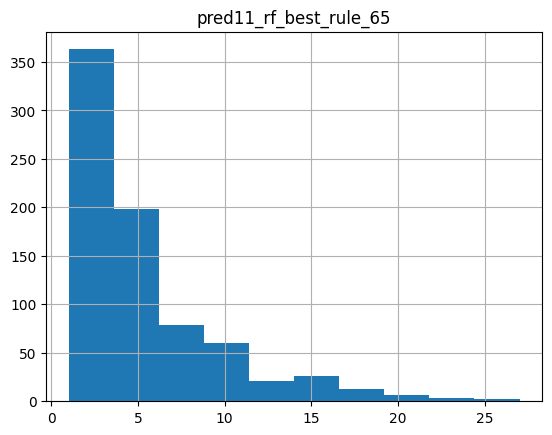

In [154]:
pred10_daily_positive_count.hist()

In [155]:
# 75% cases we have not more than 6 bets of $100
pred10_daily_positive_count.describe().T

,count,mean,std,min,25%,50%,75%,max
pred11_rf_best_rule_65,771.0,5.123217,4.419158,1.0,2.0,4.0,7.0,27.0


array([[<Axes: title={'center': 'pred10_rf_best_rule_55'}>]], dtype=object)

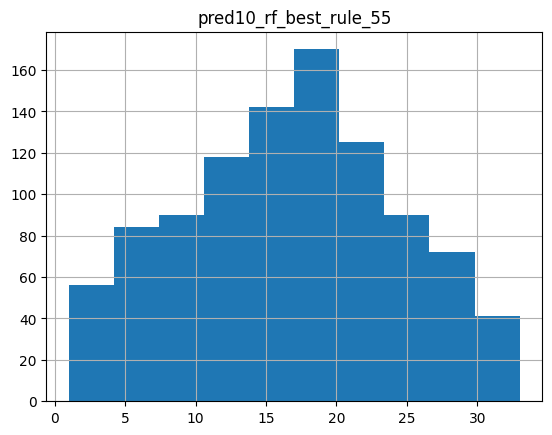

In [156]:
pred9_daily_positive_count.hist()

In [157]:
pred9_daily_positive_count.describe().T

,count,mean,std,min,25%,50%,75%,max
pred10_rf_best_rule_55,988.0,16.67004,7.555162,1.0,11.0,17.0,23.0,33.0


## 2.3) Agg. stats on ALL predictions

In [158]:
# let's review the Predictions:
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict='is_positive_growth_30d_future')


Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds', 'pred5_clf_10', 'pred6_clf_5', 'pred7_clf_second_best', 'pred8_clf_second_best_rule_84', 'pred9_clf_second_best_rule_92', 'pred10_rf_best_rule_55', 'pred11_rf_best_rule_65']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6', 'is_correct_pred7', 'is_correct_pred8', 'is_correct_pred9', 'is_correct_pred10', 'is_correct_pred11']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    443
0    351
Name: count, dtype: int64
is_correct_pred0
1    0.557935
0    0.442065
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    9748
0    8243
Name: count, dtype: i

In [159]:
# check approx. periods : Train is 2000-01...2017-01, Valid is 2017-01..2020-09, Test is 2020-09..2024-05
new_df.groupby('split').Date.agg(['min','max'])

,min,max
split,,
test,2021-08-20,2025-06-13
train,2000-01-03,2017-10-25
validation,2017-10-26,2021-08-19


In [160]:
# GET PREDICTION NUMBER: Easier solution not using regular expressions

# Example string
example_string = "pred10_rf_best_rule_60"

# Split the string by '_'
parts = example_string.split('_')

# Extract the part with 'pred' and remove the 'pred' prefix
pred_number = parts[0].replace('pred', '')

# Print the result
print(pred_number)

# Print in one line
print(int(example_string.split('_')[0].replace('pred', '')))


10
10


In [161]:
# all predictions
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds',
 'pred5_clf_10',
 'pred6_clf_5',
 'pred7_clf_second_best',
 'pred8_clf_second_best_rule_84',
 'pred9_clf_second_best_rule_92',
 'pred10_rf_best_rule_55',
 'pred11_rf_best_rule_65']

In [162]:
# all predictions on MODELS (not-manual predictions)
PREDICTIONS_ON_MODELS = [p for p in PREDICTIONS if int(p.split('_')[0].replace('pred', ''))>=5]
PREDICTIONS_ON_MODELS

['pred5_clf_10',
 'pred6_clf_5',
 'pred7_clf_second_best',
 'pred8_clf_second_best_rule_84',
 'pred9_clf_second_best_rule_92',
 'pred10_rf_best_rule_55',
 'pred11_rf_best_rule_65']

In [163]:
# all predictions on Models - correctness
IS_CORRECT_ON_MODELS = [p for p in IS_CORRECT if int(p.replace('is_correct_pred', ''))>=5]
IS_CORRECT_ON_MODELS

['is_correct_pred5',
 'is_correct_pred6',
 'is_correct_pred7',
 'is_correct_pred8',
 'is_correct_pred9',
 'is_correct_pred10',
 'is_correct_pred11']

In [164]:
# predictions on models
# pred10_rf_best_rule_60: ONLY 2% of TEST cases predicted with high confidence of growth
new_df.groupby('split')[PREDICTIONS_ON_MODELS].agg(['count','sum','mean']).T

split                                        test          train    validation
pred5_clf_10                  count  31408.000000  129730.000000  30657.000000
                              sum    18637.000000   99158.000000  23704.000000
                              mean       0.593384       0.764341      0.773200
pred6_clf_5                   count  31408.000000  129730.000000  30657.000000
                              sum    18452.000000  104161.000000  22899.000000
                              mean       0.587494       0.802906      0.746942
pred7_clf_second_best         count  31408.000000  129730.000000  30657.000000
                              sum    18879.000000   90027.000000  22690.000000
                              mean       0.601089       0.693957      0.740125
pred8_clf_second_best_rule_84 count  31408.000000  129730.000000  30657.000000
                              sum    16194.000000   33375.000000  11391.000000
                              mean       0.515601       0.257265      0.371563
pred9_clf_second_best_rule_92 count  31408.000000  129730.000000  30657.000000
                              sum    14312.000000   20121.000000   6469.000000
                              mean       0.455680       0.155099      0.211012
pred10_rf_best_rule_55        count  31408.000000  129730.000000  30657.000000
                              sum    16470.000000   78344.000000  19895.000000
                              mean       0.524389       0.603900      0.648955
pred11_rf_best_rule_65        count  31408.000000  129730.000000  30657.000000
                              sum     3950.000000   72006.000000  19014.000000
                              mean       0.125764       0.555045      0.620217

In [165]:
# 10 predictions stats (check TEST set)
new_df.groupby('split')[PREDICTIONS].agg(['count','sum','mean']).T

split                                        test          train    validation
pred0_manual_cci              count  31408.000000  129730.000000  30657.000000
                              sum      794.000000    3428.000000    886.000000
                              mean       0.025280       0.026424      0.028900
pred1_manual_prev_g1          count  31408.000000  129730.000000  30657.000000
                              sum    17991.000000   76372.000000  19721.000000
                              mean       0.572816       0.588700      0.643279
pred2_manual_prev_g1_and_snp  count  31408.000000  129730.000000  30657.000000
                              sum    13367.000000   57404.000000  16695.000000
                              mean       0.425592       0.442488      0.544574
pred3_manual_dgs10_5          count  31408.000000  129730.000000  30657.000000
                              sum      997.000000   13333.000000  11908.000000
                              mean       0.031744       0.102775      0.388427
pred4_manual_dgs10_fedfunds   count  31408.000000  129730.000000  30657.000000
                              sum     5660.000000   30611.000000      0.000000
                              mean       0.180209       0.235959      0.000000
pred5_clf_10                  count  31408.000000  129730.000000  30657.000000
                              sum    18637.000000   99158.000000  23704.000000
                              mean       0.593384       0.764341      0.773200
pred6_clf_5                   count  31408.000000  129730.000000  30657.000000
                              sum    18452.000000  104161.000000  22899.000000
                              mean       0.587494       0.802906      0.746942
pred7_clf_second_best         count  31408.000000  129730.000000  30657.000000
                              sum    18879.000000   90027.000000  22690.000000
                              mean       0.601089       0.693957      0.740125
pred8_clf_second_best_rule_84 count  31408.000000  129730.000000  30657.000000
                              sum    16194.000000   33375.000000  11391.000000
                              mean       0.515601       0.257265      0.371563
pred9_clf_second_best_rule_92 count  31408.000000  129730.000000  30657.000000
                              sum    14312.000000   20121.000000   6469.000000
                              mean       0.455680       0.155099      0.211012
pred10_rf_best_rule_55        count  31408.000000  129730.000000  30657.000000
                              sum    16470.000000   78344.000000  19895.000000
                              mean       0.524389       0.603900      0.648955
pred11_rf_best_rule_65        count  31408.000000  129730.000000  30657.000000
                              sum     3950.000000   72006.000000  19014.000000
                              mean       0.125764       0.555045      0.620217

# 3) Trading Simulations

* create simulation 1 features: like "sim1_pred0" ... "sim1_pred10"

## 3.1) Investing $100 on every positive prediction
* fees = 0.1% for each buy and sell operation ==> 0.2% for buy+sell operation

### [Code Snippet 7] 3.1.1 Calculate fin. result from simulations for one predictor 'pred6_clf_best'

In [166]:
# current prediction
pred = 'pred6_clf_5'

In [167]:
# Total Number of Investment Opportunities
new_df[new_df.split=='test'].Close_x.count()

np.int64(31408)

In [168]:
# Total Number of Days (~4 years of trading)
new_df[new_df.split=='test'].Date.nunique()

991

In [169]:
# check actual future growth with 'growth_future_5d', correctness of the prediction with 'is_positive_growth_5d_future'
TO_PREDICT

['growth_future_30d', 'is_positive_growth_30d_future']

In [170]:
# SAMPLE: compare the predictions from pred6_clf_best to real is_positive_growth_30d_future
new_df[['growth_future_30d','is_positive_growth_30d_future',pred]].sample(10)

,growth_future_30d,is_positive_growth_30d_future,pred6_clf_5
3000,1.648793,1,1
9726,1.043885,1,1
9566,0.976190,0,0
8480,0.997150,0,1
1000,1.020422,1,0
6170,0.839751,0,1
3366,1.028165,1,0
4127,0.973583,0,1
4630,0.910370,0,1
3688,1.042990,1,1


In [171]:
# GROSS REVENUE: ONLY when current_prediction equals to 1: invest $100 into that stock (buy), and sell in 1week (sell)
new_df['sim1_gross_rev_pred6'] = new_df[pred] * 100 * (new_df['growth_future_30d']-1)

In [172]:
# FEES: 0.1% for each operation , 0.2% for buy+sell ONLY when current_prediction equals to one
new_df['sim1_fees_pred6'] = -new_df[pred] * 100 * 0.002

In [173]:
# NET REVENUE: GROSS_REVENUE + FEES
new_df['sim1_net_rev_pred6'] = new_df['sim1_gross_rev_pred6'] + new_df['sim1_fees_pred6']

In [174]:
# sample results
COLUMNS_FIN_RESULT = ['Date','Ticker','Close_x']+TO_PREDICT+ [pred,  'sim1_gross_rev_pred6','sim1_fees_pred6','sim1_net_rev_pred6']
new_df[(new_df.split=='test')&(new_df[pred]==1)][COLUMNS_FIN_RESULT].sample(10)

,Date,Ticker,Close_x,growth_future_30d,is_positive_growth_30d_future,pred6_clf_5,sim1_gross_rev_pred6,sim1_fees_pred6,sim1_net_rev_pred6
13208,2024-10-18,LLY,913.003906,0.872713,0,1,-12.728664,-0.2,-12.928664
5051,2022-10-25,LT.NS,1881.788574,1.112154,1,1,11.215422,-0.2,11.015422
2865,2023-10-09,META,316.866577,1.067879,1,1,6.787935,-0.2,6.587935
7354,2024-12-04,SAP,253.610001,1.061827,1,1,6.182725,-0.2,5.982725
6791,2023-05-09,SIE.DE,143.121231,1.072225,1,1,7.222520,-0.2,7.022520
6205,2024-02-20,OR.PA,429.105438,0.947813,0,1,-5.218660,-0.2,-5.418660
6668,2022-11-11,SIE.DE,113.167664,1.048450,1,1,4.845018,-0.2,4.645018
5291,2023-10-13,LT.NS,3037.176758,0.998107,0,1,-0.189345,-0.2,-0.389345
5571,2024-12-05,LT.NS,3796.145996,0.931385,0,1,-6.861458,-0.2,-7.061458
4915,2024-02-29,GOOG,138.954041,1.138861,1,1,13.886105,-0.2,13.686105


In [175]:
# DAILY INVESTMENTS
filter_test_and_positive_pred = (new_df.split=='test')&(new_df[pred]==1)
df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
sim1_avg_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
print(sim1_avg_investments_per_day)

33.0


In [176]:
# how many times do we invest daily (a lot)
df_investments_count_daily.describe().T

,count,mean,std,min,25%,50%,75%,max
pred6_clf_5,585.0,31.54188,4.708493,8.0,33.0,33.0,33.0,33.0


In [177]:
new_df[(new_df.split=='test')&(new_df[pred]==1)][['sim1_gross_rev_pred6','sim1_fees_pred6','sim1_net_rev_pred6']].sum()

sim1_gross_rev_pred6    66649.328987
sim1_fees_pred6         -3690.400000
sim1_net_rev_pred6      62985.328987
dtype: float64

### 3.1.2 Calculate fin. results for all fields
* Simplified and approximate calculation

In [178]:
# Calculate fin. result for ALL predictions (manual and produced by models)

sim1_results = [] # results in Array

# Iterate over all predictions
for pred in PREDICTIONS:
  print(f'Calculating sumulation for prediction {pred}:')
  print(f"    Count times of investment {len(new_df[(new_df.split=='test')&(new_df[pred]==1)])} out of {len(new_df[(new_df.split=='test')])} TEST records")

  # Prefix: e.g. pred1 or pred10
  pred_prefix= pred.split('_')[0]

  # Fin. result columns: define new records for EACH positive prediction
  new_df['sim1_gross_rev_'+pred_prefix] = new_df[pred] * 100 * (new_df['growth_future_30d']-1)
  new_df['sim1_fees_'+pred_prefix] = -new_df[pred] * 100 * 0.002
  new_df['sim1_net_rev_'+pred_prefix] = new_df['sim1_gross_rev_'+pred_prefix] + new_df['sim1_fees_'+pred_prefix]

  # calculate agg. results for each PREDICTION columns (pred) on TEST
  filter_test_and_positive_pred = (new_df.split=='test')&(new_df[pred]==1) # filter records on TEST set, when current prediction is 1 (we invest $100 for 1 week ahead - 5 periods)
  sim1_count_investments = len(new_df[filter_test_and_positive_pred])
  sim1_gross_rev = new_df[filter_test_and_positive_pred]['sim1_gross_rev_'+pred_prefix].sum()
  sim1_fees = new_df[filter_test_and_positive_pred]['sim1_fees_'+pred_prefix].sum()
  sim1_net_rev = new_df[filter_test_and_positive_pred]['sim1_net_rev_'+pred_prefix].sum()

  if sim1_gross_rev>0:
    sim1_fees_percentage = -sim1_fees/sim1_gross_rev
  else:
    sim1_fees_percentage = None

  if sim1_count_investments>0:
    sim1_average_net_revenue = sim1_net_rev/sim1_count_investments
  else:
    sim1_average_net_revenue = None

  # APPROXIMATE CAPITAL REQUIRED and CAGR Calculation
  df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
  sim1_avg_investments_per_day = df_investments_count_daily[pred].mean()
  sim1_q75_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
  # df_investments_count_daily[pred].mean()
  sim1_capital = 100 * 30 * sim1_q75_investments_per_day # 30 (trading) days  in a row with positive predictions
  # CAGR: average growth per year. E.g. if you have 1.5 return (50% growth in 4 years) --> (1.5)**(1/4) = 1.106 or 10.6% average
  sim1_CAGR = ((sim1_capital+sim1_net_rev)/sim1_capital)**(1/4)

  # append to DF
  sim1_results.append((pred,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR))


  # output for all predictions with some positive predictions
  if  sim1_count_investments>1:
    print(f"    Financial Result: \n {new_df[filter_test_and_positive_pred][['sim1_gross_rev_'+pred_prefix,'sim1_fees_'+pred_prefix,'sim1_net_rev_'+pred_prefix]].sum()}")
    print(f"        Count Investments in 4 years (on TEST): {sim1_count_investments}")
    print(f"        Gross Revenue: ${int(sim1_gross_rev)}")
    print(f"        Fees (0.2% for buy+sell): ${int(-sim1_fees)}")
    print(f"        Net Revenue: ${int(sim1_net_rev)}")
    print(f"        Fees are {int(-100.0*sim1_fees/sim1_gross_rev)} % from Gross Revenue")
    print(f"        Capital Required : ${int(sim1_capital)} (Vbegin)")
    print(f"        Final value (Vbegin + Net_revenue) : ${int(sim1_capital + sim1_net_rev)} (Vfinal)")

    print(f"        Average CAGR on TEST (4 years) : {np.round(sim1_CAGR,3)}, or {np.round(100.0*(sim1_CAGR-1),1)}% ")

    print(f"        Average daily stats: ")
    print(f"            Average net revenue per investment: ${np.round(sim1_net_rev/sim1_count_investments,2)} ")
    print(f"            Average investments per day: {int(np.round(sim1_avg_investments_per_day))} ")
    print(f"            Q75 investments per day: {int(np.round(sim1_q75_investments_per_day))} ")
    print('=============================================+')


# results in a DataFrame from an Array
columns_simulation = ['prediction', 'sim1_count_investments', 'sim1_gross_rev', 'sim1_fees', 'sim1_net_rev', 'sim1_fees_percentage','sim1_average_net_revenue','sim1_avg_investments_per_day','sim1_capital','sim1_CAGR']

df_sim1_results = pd.DataFrame(sim1_results,columns=columns_simulation)

Calculating sumulation for prediction pred0_manual_cci:
    Count times of investment 794 out of 31408 TEST records
    Financial Result: 
 sim1_gross_rev_pred0    1613.043262
sim1_fees_pred0         -158.800000
sim1_net_rev_pred0      1459.643262
dtype: float64
        Count Investments in 4 years (on TEST): 794
        Gross Revenue: $1613
        Fees (0.2% for buy+sell): $158
        Net Revenue: $1459
        Fees are 9 % from Gross Revenue
        Capital Required : $6000 (Vbegin)
        Final value (Vbegin + Net_revenue) : $7459 (Vfinal)
        Average CAGR on TEST (4 years) : 1.056, or 5.6% 
        Average daily stats: 
            Average net revenue per investment: $1.84 
            Average investments per day: 2 
            Q75 investments per day: 2 
=============================================+
Calculating sumulation for prediction pred1_manual_prev_g1:
    Count times of investment 17991 out of 31408 TEST records
    Financial Result: 
 sim1_gross_rev_pred1    29618

In [179]:
df_sim1_results['sim1_growth_capital_4y'] = (df_sim1_results.sim1_net_rev+df_sim1_results.sim1_capital) / df_sim1_results.sim1_capital

In [180]:
# final comparison
df_sim1_results

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
0,pred0_manual_cci,794,1613.043262,-158.8,1459.643262,0.098447,1.838342,1.850816,6000.0,1.055946,1.243274
1,pred1_manual_prev_g1,17991,29618.243475,-3598.2,26167.843475,0.121486,1.454496,18.154390,75000.0,1.077694,1.348905
2,pred2_manual_prev_g1_and_snp,13367,17019.666162,-2673.4,14475.066162,0.157077,1.082896,22.967354,81000.0,1.041960,1.178705
3,pred3_manual_dgs10_5,997,2845.843984,-199.4,2646.443984,0.070067,2.654407,31.156250,96000.0,1.006822,1.027567
4,pred4_manual_dgs10_fedfunds,5660,8594.814190,-1132.0,7660.814190,0.131707,1.353501,31.620112,99000.0,1.018808,1.077382
5,pred5_clf_10,18637,50115.204519,-3727.4,46462.404519,0.074377,2.493020,18.959308,90000.0,1.109667,1.516249
6,pred6_clf_5,18452,66649.328987,-3690.4,62985.328987,0.055370,3.413469,31.541880,99000.0,1.130994,1.636215
7,pred7_clf_second_best,18879,52059.311409,-3775.8,48369.511409,0.072529,2.562080,19.050454,78000.0,1.128202,1.620122
8,pred8_clf_second_best_rule_84,16194,50824.171338,-3238.8,47661.371338,0.063726,2.943150,16.390688,66000.0,1.145558,1.722142
9,pred9_clf_second_best_rule_92,14312,48035.212554,-2862.4,45248.012554,0.059590,3.161544,14.604082,60000.0,1.150842,1.754134


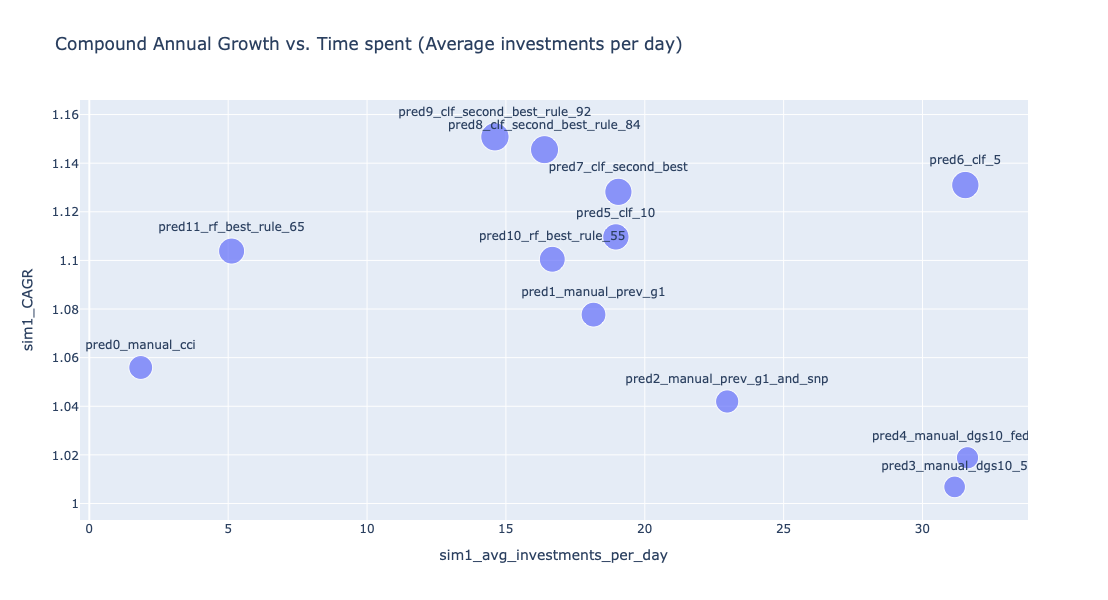

In [181]:
# Create the scatter plot
fig = px.scatter(
    df_sim1_results.dropna(),
    x='sim1_avg_investments_per_day',
    y='sim1_CAGR',
    size='sim1_growth_capital_4y',  # Use the 'size' parameter for sim1_CAGR
    text='prediction',
    title='Compound Annual Growth vs. Time spent (Average investments per day)',
    labels={'sim1_capital': 'Initial Capital Requirement', 'growth_capital_4y': '4-Year Capital Growth'},
    height=600  # <- Increase height here

)

# Update the layout to improve readability of the annotations
fig.update_traces(textposition='top center')

# Show the plot
fig.show()

In [182]:
# detailed info from the bubble chart above on the winners
# top 1 result
df_sim1_results[df_sim1_results.prediction.isin(['pred9_clf_second_best_rule_92'])]

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
9,pred9_clf_second_best_rule_92,14312,48035.212554,-2862.4,45248.012554,0.05959,3.161544,14.604082,60000.0,1.150842,1.754134


In [183]:
# top 2-3 results
df_sim1_results[df_sim1_results.prediction.isin(['pred8_clf_second_best_rule_84','pred7_clf_second_best'])]

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
7,pred7_clf_second_best,18879,52059.311409,-3775.8,48369.511409,0.072529,2.56208,19.050454,78000.0,1.128202,1.620122
8,pred8_clf_second_best_rule_84,16194,50824.171338,-3238.8,47661.371338,0.063726,2.94315,16.390688,66000.0,1.145558,1.722142
